# The Quantum Autoencoder

In this tutorial, we explain the architecture of a Quantum Autoencoder and how one can design and train such a system to compress and encode information. Following this discussion, we give two examples to demonstrate the capabilities of such a system to compress different quantum states, as well as the ability to compress images of zeros and ones. 

## Contents

The following tutorial is broken down as follows:

1. What is an Autoencoder?
1. The Quantum Autoencoder (QAE)
3. Components of a QAE
4. Choosing a Loss Function
5. Building our Autoencoder
6. A Simple Example: The Domain Wall
7. A QAE for Noisy Images of Digits
8. References 

## 1. What is an Autoencoder?

A classical autoencoder (CAE) is a type of neural network architecture that is commonly used to efficiently compress and encode information from the input using of representation learning. Following compression, one can then uncompress the data through the use of a decoder. 

Typical autoencoders are commonly divided into three layers, as seen in Figure 1. 

<div>
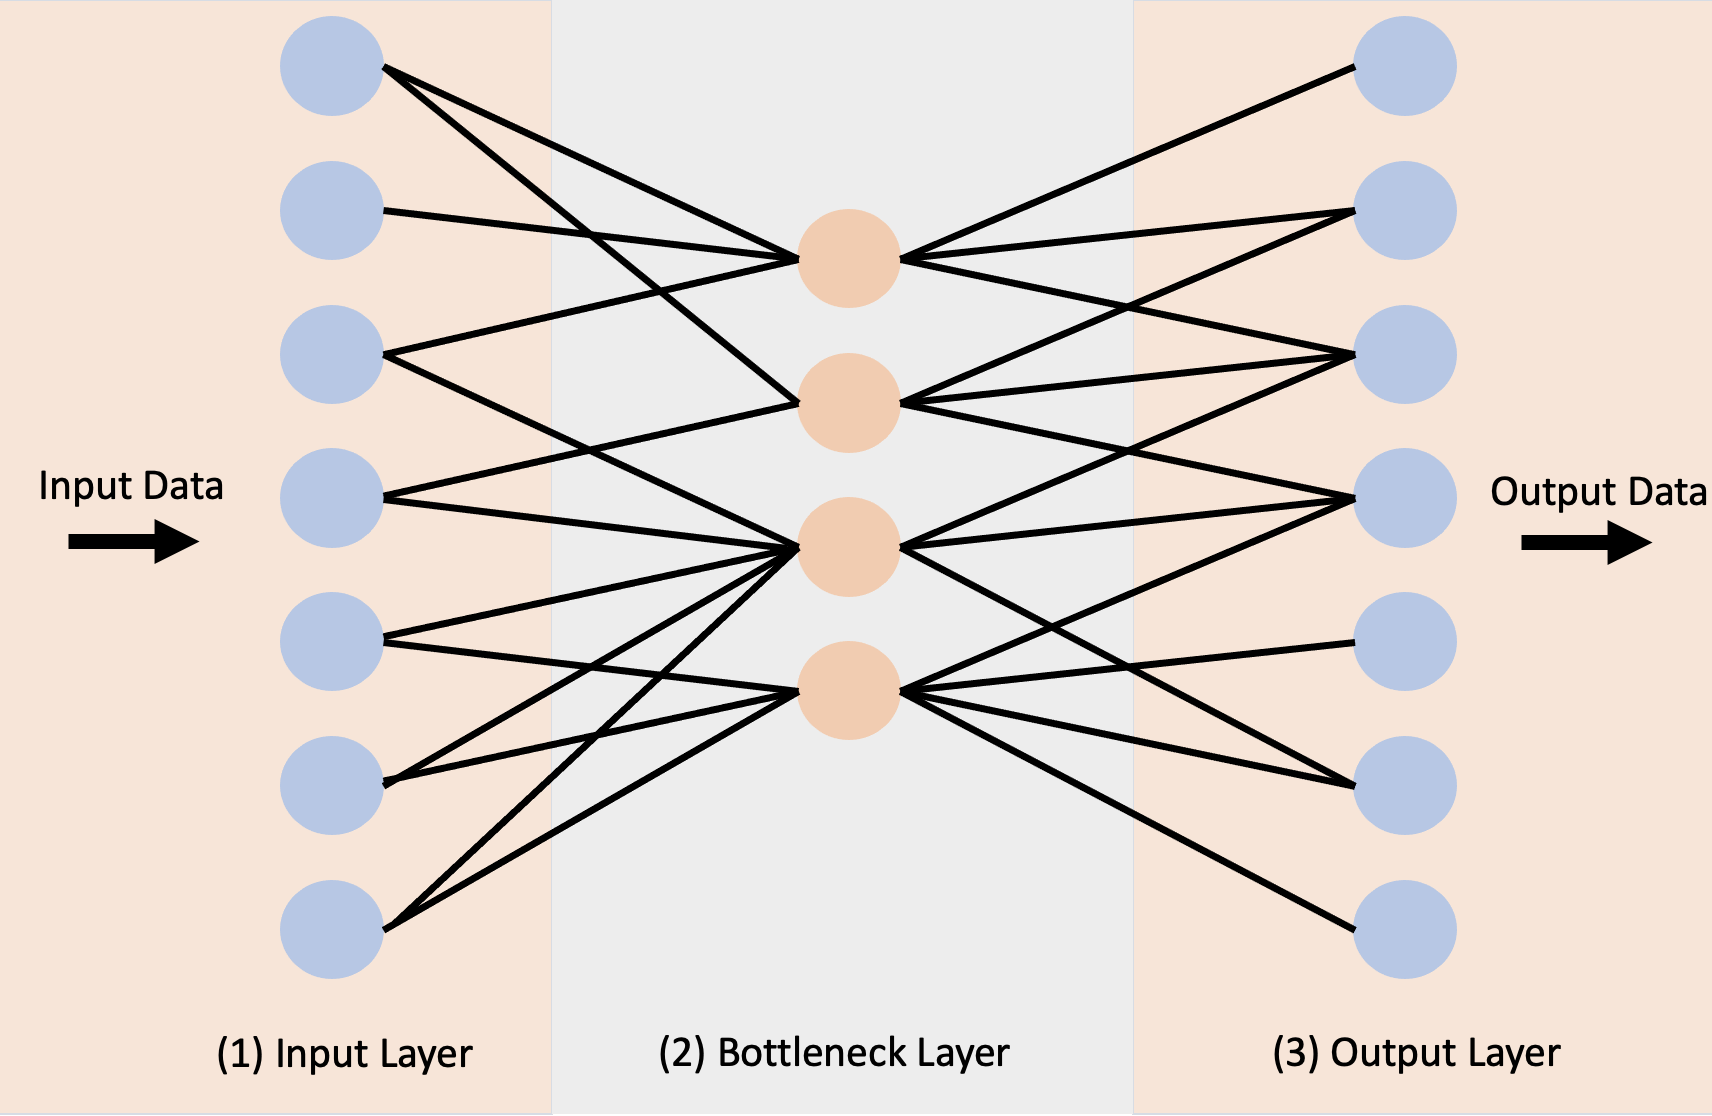
</div>

Figure 1: Example of a Classical Autoencoder which includes the input, bottleneck and output layer.

The first layer is called the Input Layer (1) and is the layer of which we input our data of length $n$. 

The input data then passes through an encoder and travels to the next layer, which has a less nodes or is reduced in dimensions and is known as the Bottleneck Layer (2). The input layer is compressed through this process. Common CAEs may have several layers.

The final layer is called the Output Layer (3). Here the compressed data is reconstructed to its original size, $n$, from the compressed data through the process of a decoder. 

By passing our input data through a CAE, we are therefore able to reduce the dimensionality of our input data, as seen in the bottleneck layer, while retaining as much information as possible from the input data. Because of this feature, common uses of CAE are Image Denoising, Anomaly Detection and Facial Recognition devices. For more information on classical autoencoders, see [1].

## 2. The Quantum Autoencoder (QAE)

We can also define a quantum counterpart to the CAE, the Quantum Autoencoder (QAE). Much like the CAE, the QAE aims to reduce the dimensionality of the input of the neural network, in this case a quantum state. A pictorial representation of this can be seen in Figure 2.


<div>
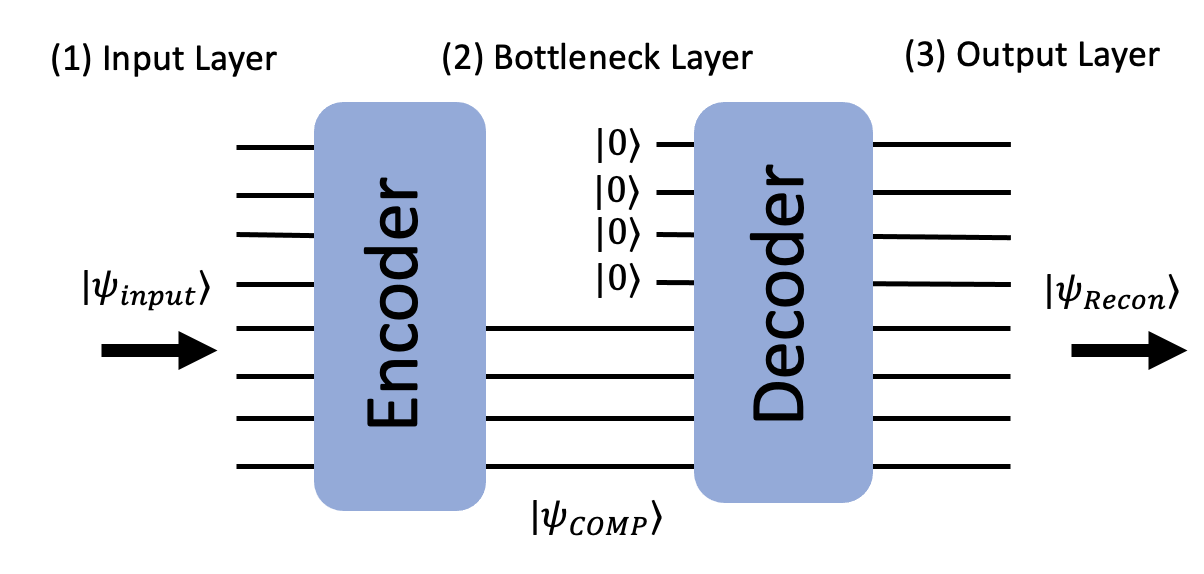
</div>

Figure 2: Pictorial Representation of a QAE. Here one can see the similarities with the CAE, with the circuit having an input state, bottleneck state and an output state.

 

Much like its classical counterpart, our circuit contains three layers. We first input our state $|\psi>$ (which contains $n$ qubits), of which we wish to compress. This is our input layer (1). 

We then apply our parametrized circuit on our input state, which will act as our encoder and 'compresses' our quantum state, reducing the dimensionality of our state to $n-k$ qubits. Our new compressed state is of the form $|\psi_{comp}> \otimes |0>^{\otimes k}$, where $|\psi_{comp}>$ contains $n-k$ qubits. 

This parametrized circuit will depend on a set of parameters, which will be the nodes of our QAE. Throughout the training process, these parameters will be updated to optimize the loss function. 

We disregard the remaining $k$ qubits for the remainder of the circuit. This is our bottleneck layer (2) and our input state is now compressed. 

The final layer consists of the addition of $k$ qubits (all in the state $|0\rangle$) and applying another parametrized circuit between the compressed state and the new qubits. This parametrized circuit acts as our decoder and reconstructs the input state from the compressed state using the new qubits. After the decoder, we retain the original state as the state travels to the output layer (3).

## 3. Components of a QAE

Before building our QAE, we must note a few subtleties.

We first note that we cannot introduce or disregard qubits in the middle of a Quantum Circuit when implementing an autoencoder using Qiskit. 

Because of this we must include our reference state as well as our ancilla qubits (whose role will be described in later sections) at the beginning of the circuit. 

Therefore our input state will consist of our input state, reference state and one ancilla qubit, as well as a classical register to perform measurements (which will be described in the next section). A pictorial representation of this can be seen in Figure 3. 

<div>
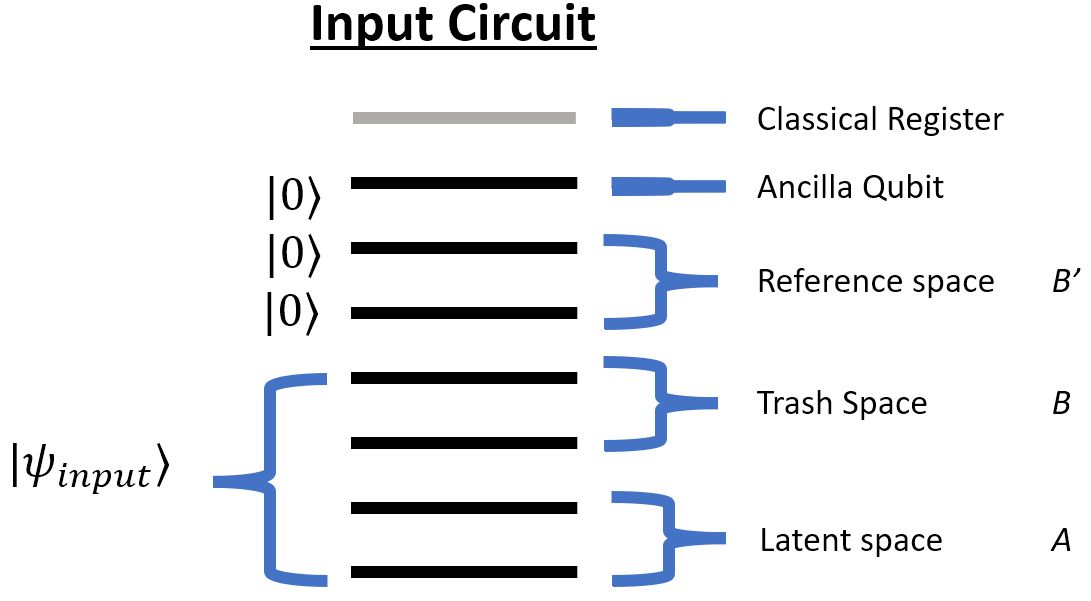
</div>
Figure 3: Pictorial Representation of input state of QAE. Note that we must also include an ancilla qubit, the reference state and classical register at the beginning of the circuit, even though they are not used until later in the circuit. 

## 4. Choosing a Loss Function 

We now define our cost function, which we will use to train our QAE, to return the input state. There's a bit of math involved here, so skip this section if you're not interested! 

We take the cost function as defined in [2], which tries to maximize the fidelity between the input and output state of our QAE. 

We first define subsystems $A$ and $B$ to contain $n$ and $k$ qubits respectively, while $B'$ is the space which will contain our reference space. We call the subsystem $A$ our latent space, which will contain the compressed qubit state, and $B$ our trash space, which contain the qubits of which we disregard throughout compression. 

Our input state therefore $|\psi_{AB}>$ contains $n + k$ qubits. We define the reference space $B'$ which contains the reference state $|a>_{B'}$. This space will contain the additional $k$ qubits we use in the decoder. All of these subsystems can be seen in Figure 3. 

We define the parameterized circuit as $U(\theta)$ which we will use as our encoder. However the structure and parameters of our parametrized circuit is currently unknown to us and may vary for different input states. To determine the parameters to compress our input state, we must train our device to maximally compress the state by adjusting the values of the parameters $\theta$. For the decoder we will use $U^{\dagger}(\theta)$.

Our goal therefore is to maximize the fidelity between the input and output states, i.e.

$$\text{max }F(\psi_{AB}, \rho_{out})$$

where

$$\rho_{out} = U^{\dagger}(\theta)_{AB'} \text{Tr}_{B} [U(\theta)_{AB}[\psi_{AB} \otimes a_{B'}]U^{\dagger}(\theta)_{AB}]U(\theta)_{AB'}$$

We can maximize this fidelity by tuning the parameters $\theta$ in our parametrized circuit. However, this fidelity can at times be complicated to determine and may require a large amount of gates needed to calculate the fidelity between two states, i.e. the larger the number of qubits, the more gates required which results to deeper circuits.  Therefore we look for alternative means of comparing the input and output states. 

As shown in [2] a simpler way of determining an optimally compressed state is to perform a swap gate between the trash state and reference state. These states usually have a smaller number of qubits and are therefore easier to compare, due to the smaller amount of gates required. As shown in [2] maximizing the fidelity of such these two states is equivalent to maximizing the fidelity of the input and output state and thus determining an optimal compression of our input circuit. 

Keeping our reference state fixed, our cost function will now be a function of the trash state and is denoted as; 

$$\text{max }F(\text{Tr}_{A} [ U(\theta)_{AB}\psi_{AB} U^{\dagger}(\theta)_{AB}], a_{B'})$$

Throughout the training process, we adjust the parameters $\theta$ in our encoder and perform a swap test (as described below) to determine the fidelity between these trash and reference states. In doing so, we must include an additional qubit, our ancilla qubit, which will be used throughout the swap test and measured to determine the overall fidelity of the trash and reference states. This is the reason why we included both an ancilla qubit and classical register in the previous section when initializing our circuit.  

### The SWAP Test

The SWAP Test is a procedure commonly used to compare two states by applying CNOT gates to each qubit (for further information see [3]). By running the circuit $M$ times, and applying the SWAP test, we then measure the ancilla qubit. We use the number of states in the state $|1\rangle$ to compute:

$$S = 1 - \frac{2}{M}L$$

where $L$ is the count for the states in the $|1\rangle$ state. As shown in [3], maximizing this function corresponds to the two states of which we are comparing being identical. We therefore aim to maximize this function, i.e. minimize  $\frac{2}{M}L$. This value will be therefore be our cost function.

## 5. Building the QAE Ansatz

First, we implement IBM's Qiskit to build our QAE. We first begin by importing in the necessary libraries and fixing the seed.

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import CircuitQNN

algorithm_globals.random_seed = 42

Then we define a quantum instance with a number of shots set to 8192.

In [2]:
shots = 8192
qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=shots)

We begin by defining our parametrized ansatz for the QAE. This will be our parametrized circuit where we can tune the parameters to maximize the fidelity between the trash and reference states. 

### The Parametrized Circuit 

The parametrized circuit we will use below for our encoder is the RealAmplitude Ansatz available in Qiskit. One of the reasons why we have chosen this ansatz is because it is a 2-local circuit, the prepared quantum states will only have real amplitudes, and does not rely on full connectivity between each qubits, which is hard to implement or can lead to deep circuits. 

We define our parametrized circuit for our Encoder below, where we set the repetition parameter to `reps=5`, to increase the number of parameters in our circuit allowing greater flexibility. 

In [3]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

Let's draw this ansatz with $5$ qubits and see what it looks like.

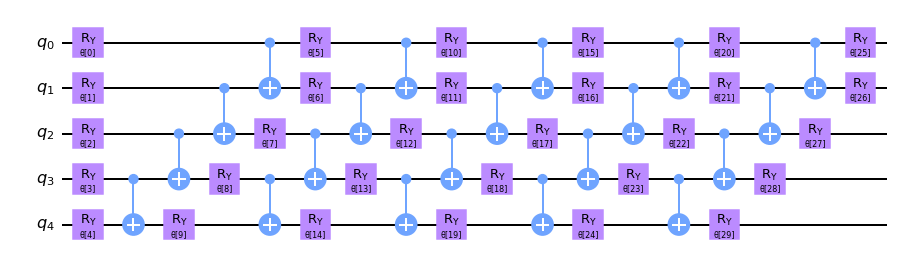

In [4]:
num_qubits = 5
circ = ansatz(num_qubits)
circ.decompose().draw("mpl")

We now apply this Encoder to the state we wish to compress. In this example, we divide our initial $5$ qubit state into a $3$ qubit latent state ($n = 3$) and $2$ qubit trash space ($k = 2$). 

As explained in the previous section, we must also include a $2$ qubit reference space in our circuit, as well as an ancilla qubit to perform the swap test between the reference and trash states. We will therefore have a total of $2 + 3 + 2 + 1 = 8$ qubits and $1$ classical register in our circuit.

After initializing our state, we apply our parametrized circuit.

Following this, we then split our initial state into the latent space (the compressed state) and trash space (the part of the state we will disregard) and perform the swap test between the reference state and the trash space. The last qubit is then measured to determine the fidelity between the reference and trash states.  A pictorial representation of this is given below in Figure 4. 

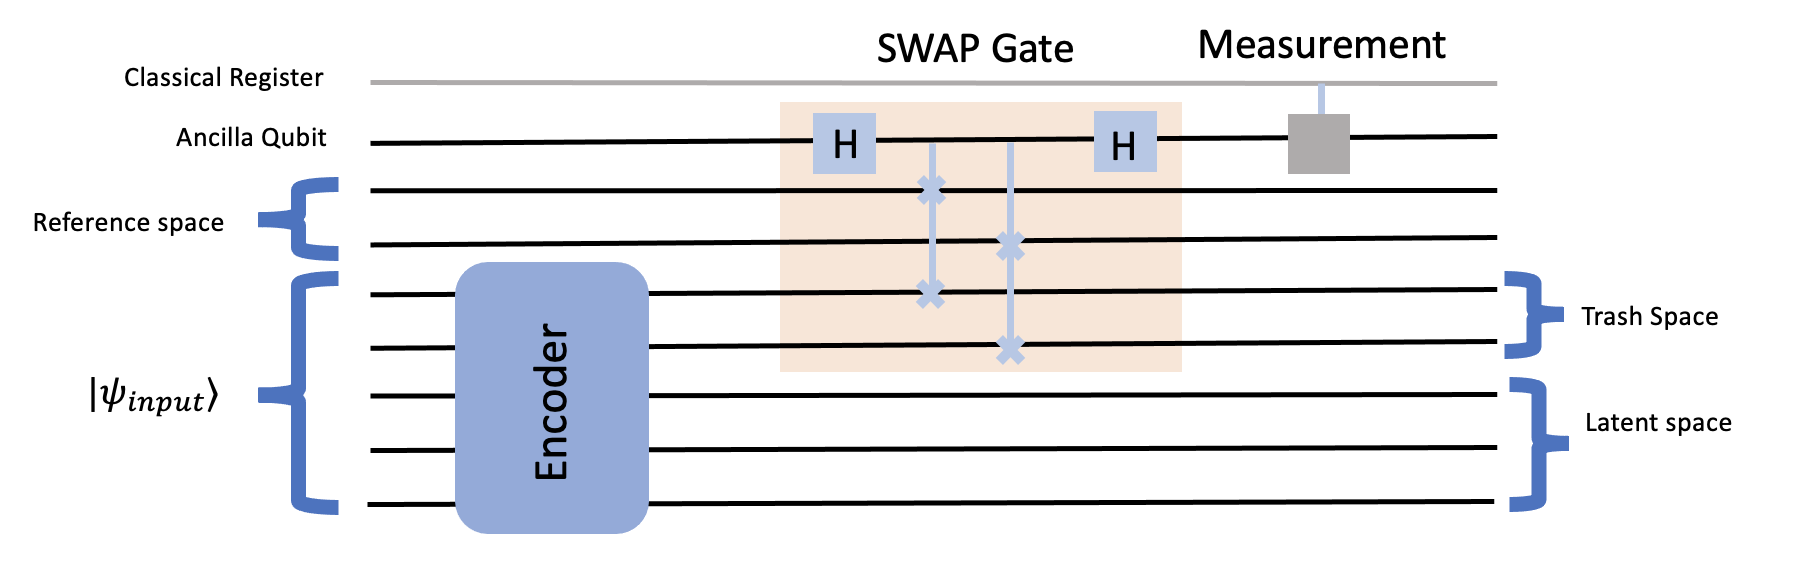

Figure 4: Example of a QAE in the training process. We use the swap test to determine the fidelity between the trash and reference space. 

We define a function below to implement the above circuit configuration to the $5$ qubit domain wall state $|00111\rangle$ and plot an example below. Here qubits $5$ and $6$ are the reference state, $0, 1, 2, 3, 4$ are the initial state we wish to compress and qubit $7$ is our ancilla qubit which is used in the swap test. We also include a classical register to measure the results of qubit $7$ in the swap test. 

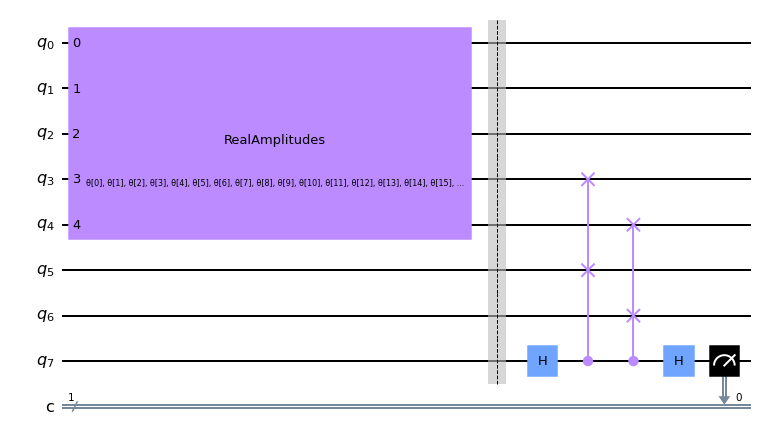

In [5]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    ancilla_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(ancilla_qubit)
    for i in range(num_trash):
        circuit.cswap(ancilla_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(ancilla_qubit)
    circuit.measure(ancilla_qubit, cr[0])
    return circuit


num_latent = 3
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw("mpl")

In order to reconstruct the original input state, we must apply the adjoint of our parametrized circuit after the swap test. However, during training, we are only interested in the trash state and the reference state. We can therefore exclude the gates following compression until we wish to reconstruct our initial input. 

After building our QAE, the next step is to train our QAE to compress the state and maximize the cost function and determine the parameters $\theta$. 

## 6. A Simple Example: The Domain Wall Autoencoder

Let's first begin with a simple example, a state known as the Domain Wall, which for $5$ qubits is given by $|00111\rangle$. Here we will try and compress this state from $5$ qubits to $3$ qubits, with the remaining qubits in the trash space, in the state $|00\rangle$. We can create a function to build the domain wall state below.

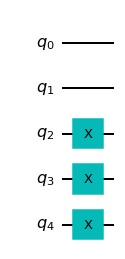

In [6]:
def domain_wall(circuit, a, b):
    # Here we place the Domain Wall to qubits a - b in our circuit
    for i in np.arange(int(b / 2), int(b)):
        circuit.x(i)
    return circuit


domain_wall_circuit = domain_wall(QuantumCircuit(5), 0, 5)
domain_wall_circuit.draw("mpl")

Now let's train our Autoencoder to compress this state from 5 qubits to 3 qubits (qubits 0,1 and 2), with the remaining qubits in the trash space (qubits 3 and 4) being in the |00> state. 

We create a circuit to be used in the loss function, as described in Section 4, which determines the fidelity between the two states below using the swap test for our particular AutoEncoder function. For further information on the swap test, see [1]. 

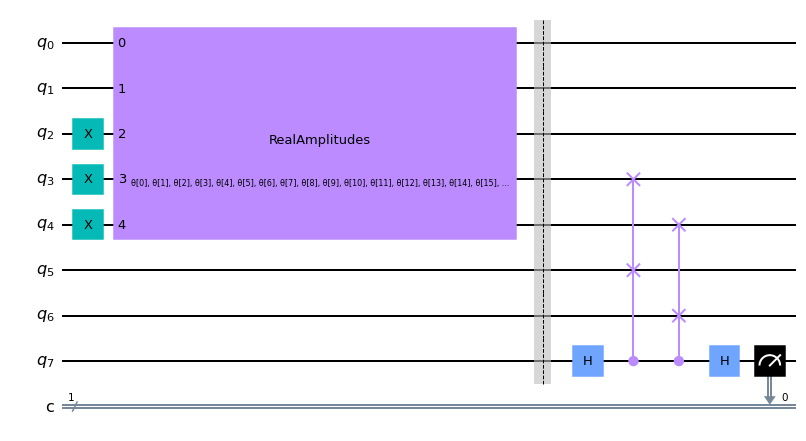

In [7]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw("mpl")

Then, we create a quantum neural network and pass the circuit as a parameter. We note that this network must take an interpret function, which determines how we map the output of the network to the output shape. Since we measure only one qubit, the output of the network is a bit string either $0$ or $1$, so the output shape is $2$, the number of possible outcomes. Then, we introduce an identity mapping. The output of the network is a vector of probabilities of getting interpret-mapped bit strings. Thus, we get probabilities of getting $0$ or $1$ and this is exactly what we are looking for. In the cost function we make use of the probability of getting $1$ and penalize the outcomes that lead to $1$, therefore maximizing the fidelity between the trash space and the reference space.

In [8]:
# Here we define our interpret for our CircuitCNN
def identity_interpret(x):
    return x


qnn = CircuitQNN(
    qc, [], ae.parameters, interpret=identity_interpret, output_shape=2, quantum_instance=qi_qasm
)

Next we create our cost function. As described in the previous section, our aim is to minimize $\frac{2}{M}L$, which is the twice the probability of getting the final qubit in the $|1\rangle$ state. We therefore wish to minimize the of getting a $|1\rangle$ on qubit 7.

The cost function will also plot out the objective value at each cost function evaluation.

In [9]:
def cost_func_domain(params_values):
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

Now we will train our Autoencoder to reduce the dimension of the Hilbert space from $5$ qubits to $3$, while leaving the trash space in the state $|00\rangle$.  We initially set the parameters $\theta$ to random values and tune these parameters to minimize our cost function through the use of the COBYLA optimizer. 

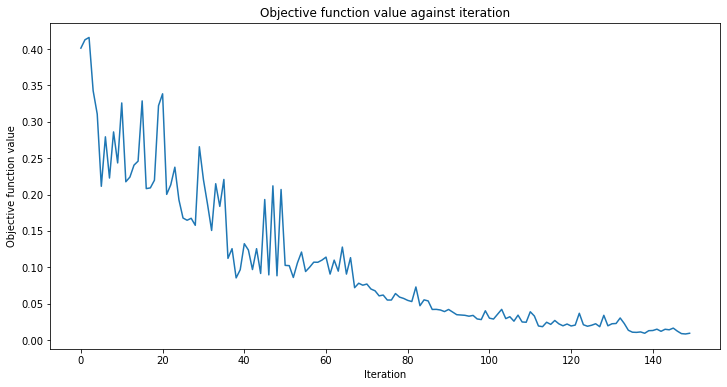

Fit in 27.71 seconds


In [10]:
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

Looks like it has converged! After training our QAE, let's build it and see how well it compresses the state! 

To do this, we first apply our Autoencoder to a $5$ qubit Domain Wall state. After applying this state, the compressed state should be of the form $|00\rangle$. Therefore resetting the last two qubits should not effect our over all state. 

After resetting we apply our decoder (the hermitian conjugate of our encoder) and compare it to the initial state by determining the fidelity. If our fidelity is one, then our Autoencoder has encoded all the information of the domain wall efficiently into a smaller set of qubits and when decoding, we retain the original state! 

Let's first apply our circuit to the Domain Wall State, using the parameters we obtained when training our QAE. (Note we have included barriers in our circuit below, however these are not necessary for the implementation of the QAE and are used to determine between different sections of our circuit). 

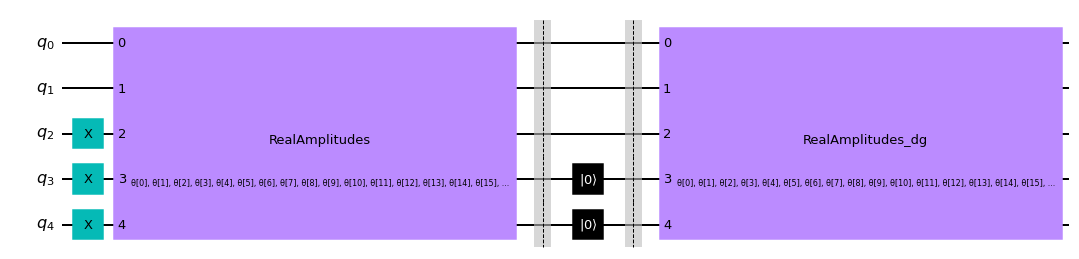

In [11]:
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(domain_wall_circuit)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw("mpl")

Now we assign the parameter values obtained in the training.

In [12]:
test_qc = test_qc.assign_parameters(opt_result.x)

Now let's get the statevectors of our Domain Wall state and output circuit and calculate the fidelity! 

In [13]:
domain_wall_state = Statevector(domain_wall_circuit).data
output_state = Statevector(test_qc).data

fidelity = np.sqrt(np.dot(domain_wall_state.conj(), output_state) ** 2)
print("Fidelity of our Output State with our Input State: ", fidelity.real)

Fidelity of our Output State with our Input State:  0.9913594757584304


As you can see our fidelity is quite high and our Autoencoder has thus compressed our dataset while retaining all the information from the input state!

Now we will see if we can apply such a QAE to more complicated datasets containing noise, such as images of the numbers zero and one. 

## 7. A QAE for Digits

One can also apply a QAE to more complicated examples, such as a set of handwritten digits in order to compress the dataset. Below, we will show that we can indeed train an QAE to compress such an example, giving us the ability to store data more efficiently on a Quantum Computer. 

For this tutorial, we will build a QAE for a noisy dataset containing zeros and ones, which can be seen below. 

Each image contains $32$ pixels of which can be encoded into $5$ qubits by Amplitude Encoding. This can be done using Qiskit's `RawFeatureVector` feature map.  

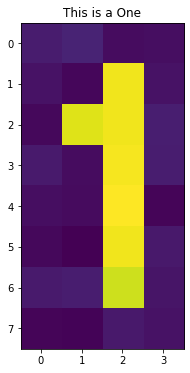

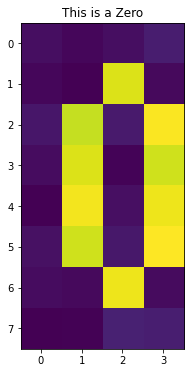

In [14]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = algorithm_globals.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = algorithm_globals.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(2)

After encoding our image into $5$ qubits, we begin to train our QAE to compress this state into $3$ qubits.

We repeat the steps in the previous example and write a cost function, again based on the Swap Test between the trash and latent space. We can also use the same Autoencoder function as given in the previous example, as the input state and trash space contain the same amount of qubits. 

Let's input one of our digits and see our circuit for the Autoencoder below. 

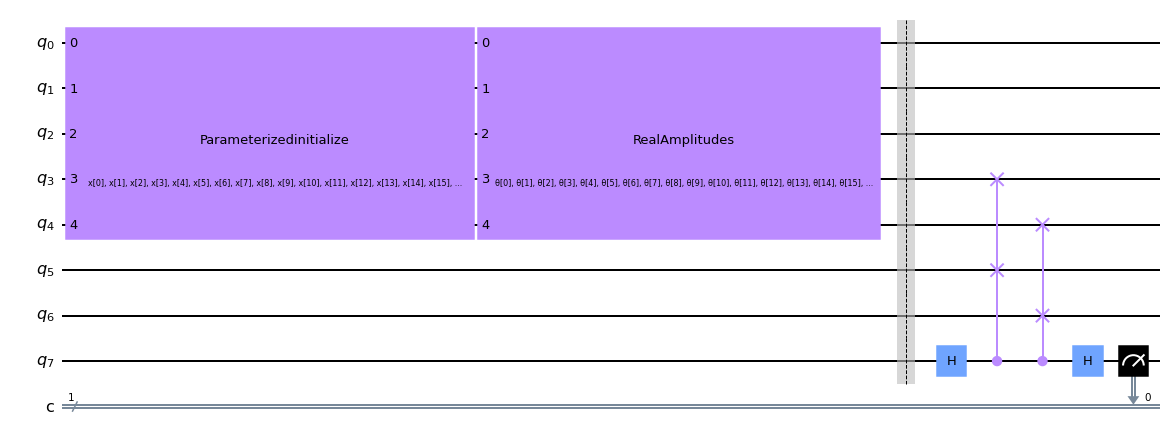

In [15]:
num_latent = 3
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw("mpl")

Again, we can see the swap test being performed on the qubits $3$, $4$, $5$ and $6$, which will determine the value of our cost function.

In [16]:
def identity_interpret(x):
    return x


# we suppress a warning that comes from RawFeatureMap
warnings.filterwarnings("ignore")

qnn = CircuitQNN(
    qc,
    fm.parameters,
    ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
    quantum_instance=qi_qasm,
)

We build our cost function, based on the swap test between the reference and trash space for the digit dataset. To do this, we again use Qiskit's CircuitQNN network and use the same interpret function as we are measuring the probability of getting the final qubit in the $|1\rangle$ state.

In [17]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

By minimizing this cost function, we can thus determine the required parameters to compress our noisy images. Let's see if we can encode our images! 

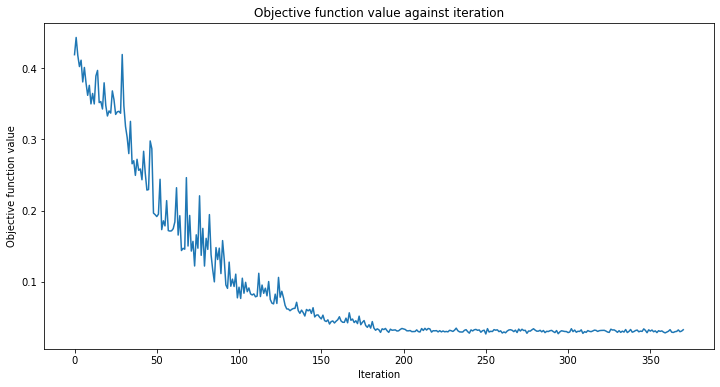

Fit in 129.96 seconds


In [18]:
opt = COBYLA(maxiter=500)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

Looks like it has converged!

Now let's build our Encoder and Decoder using the parameters obtained from the training period. After applying this circuit to our new dataset, we can then compare our input and output data and see if we were able to retain the images efficiently throughout the compression! 

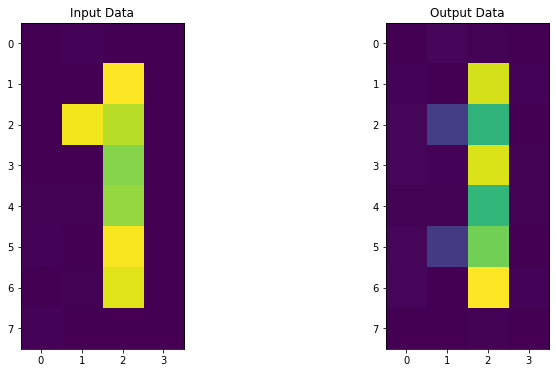

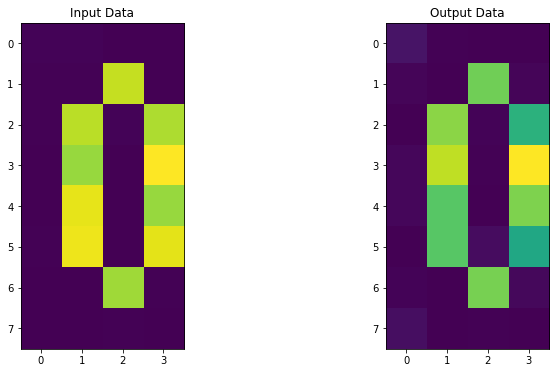

In [19]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_digits(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()

It looks like our QAE can be trained to encode digits as well! Now it's your turn to build your own QAE and come up with ideas and datasets to compress!

## 9. References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

In [20]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright